*First compiled on May 5, 2017. Updated Mar 28, 2018.*   
See the same notebook for Scanpy [0.4.4](https://github.com/theislab/scanpy_usage/blob/17c34b61f76de79bfdea7512f1782bf3f5ecb160/170505_seurat/seurat.ipynb).

# Clustering 3k PBMCs following a Seurat Tutorial

Scanpy allows to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) standard clustering tutorial as described on http://satijalab.org/seurat/pbmc3k_tutorial.html (July 26, 2017). We gratefully acknowledge  the Seurat authors for publishing the tutorial!

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/pmbc3k.h5ad'

scanpy==1.0.2 anndata==0.5.8 numpy==1.14.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
path = './data/pbmc3k_filtered_gene_bc_matrices/hg19/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]

... reading from cache file ./cache/data-pbmc3k_filtered_gene_bc_matrices-hg19-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata.var_names_make_unique()

## Preprocessing

Basic filtering.

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Plot some information about mitochondrial genes, important for quality control

In [5]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

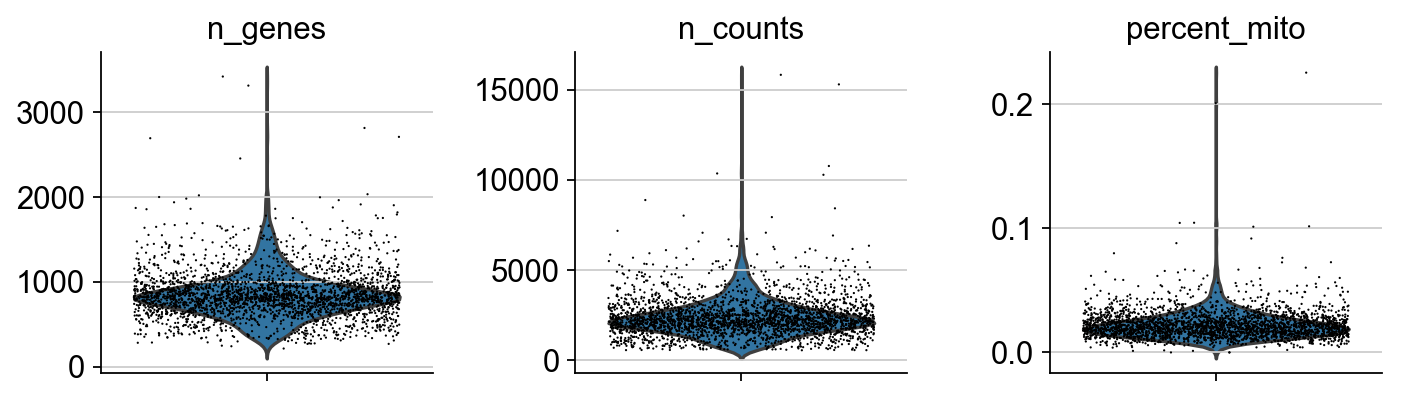

In [6]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

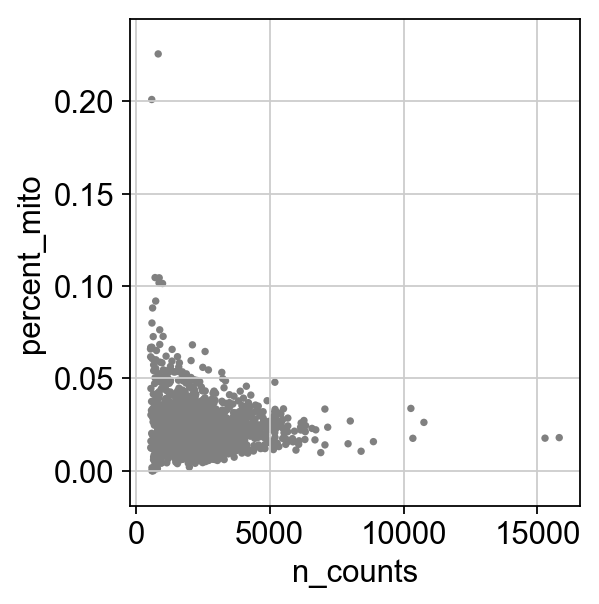

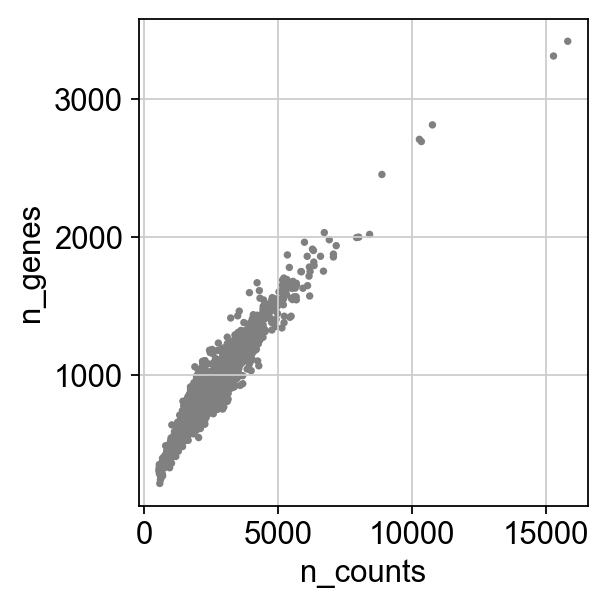

In [7]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Actually do the filtering.

In [8]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by `sc.pp.log1p`.

In [9]:
adata.raw = sc.pp.log1p(adata, copy=True)

Per-cell normalize the data matrix $\mathbf{X}$, identify highly-variable genes and compute logarithm.

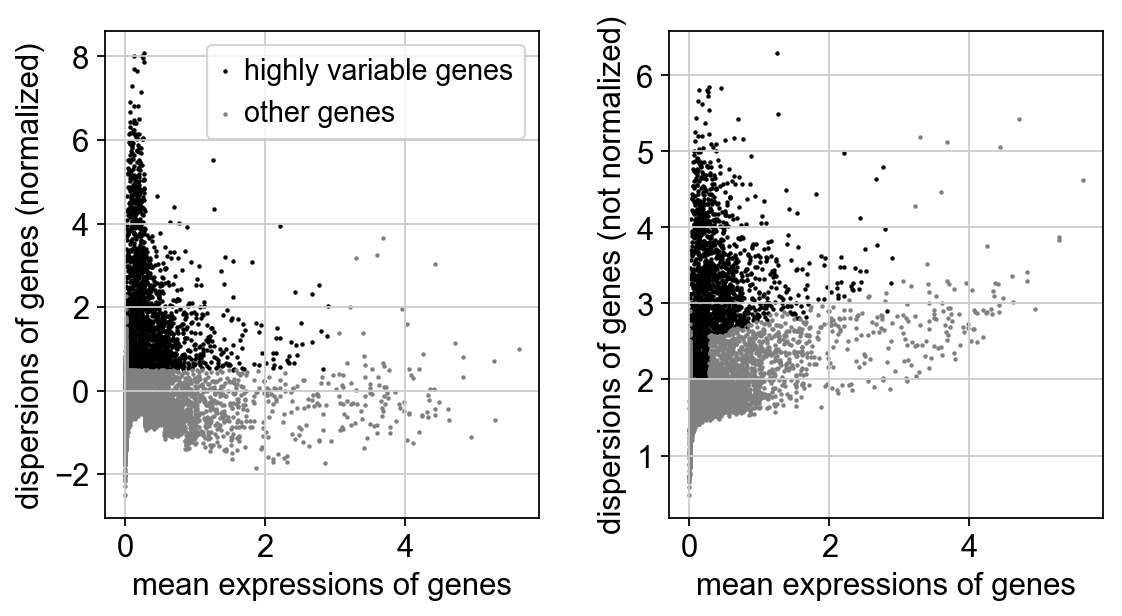

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering.

In [11]:
adata = adata[:, filter_result.gene_subset]

Logarithmize the data.

In [12]:
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [13]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:07.38)


In [14]:
sc.pp.scale(adata, max_value=10)

Save the result.

In [15]:
adata.write(results_file)

## PCA

Compute PCA and make a scatter plot.

In [16]:
sc.tl.pca(adata)

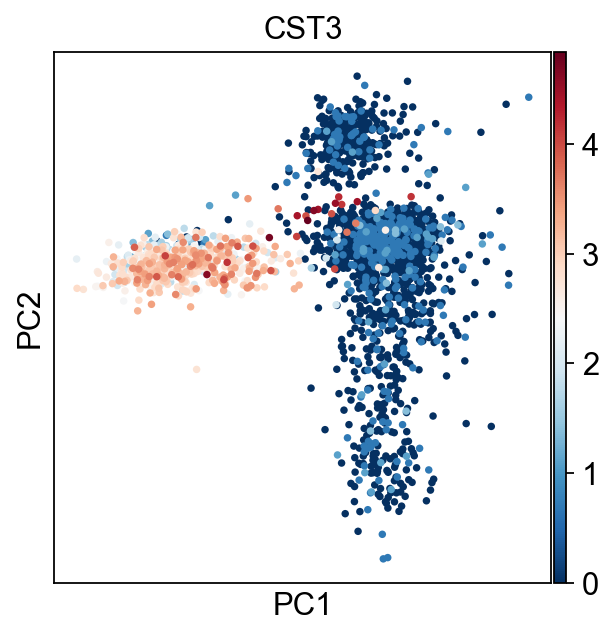

In [17]:
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

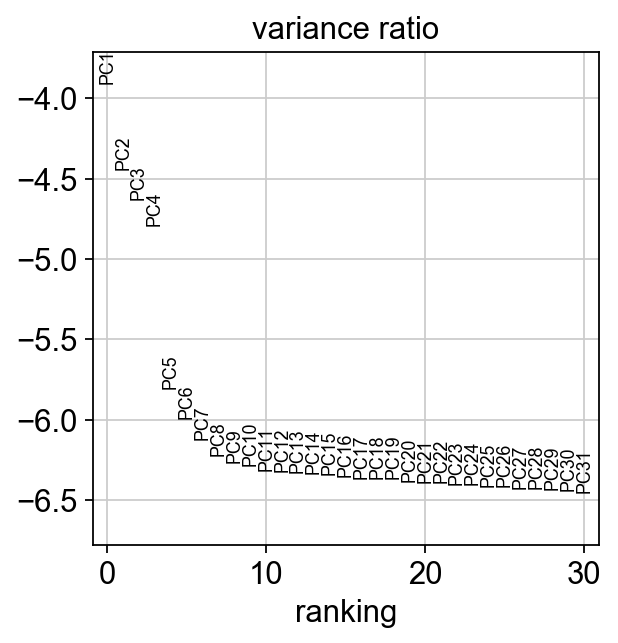

In [18]:
sc.pl.pca_variance_ratio(adata, log=True)

In [19]:
adata.write(results_file)

In [20]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## tSNE

We now advertise visualizing the data using UMAP, see below. In particular, if you have large data, this will give you a much faster first view of the data.

In [21]:
adata = sc.read(results_file)

In [22]:
sc.tl.tsne(adata, random_state=2, n_pcs=10)
adata.write(results_file)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:07.08) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


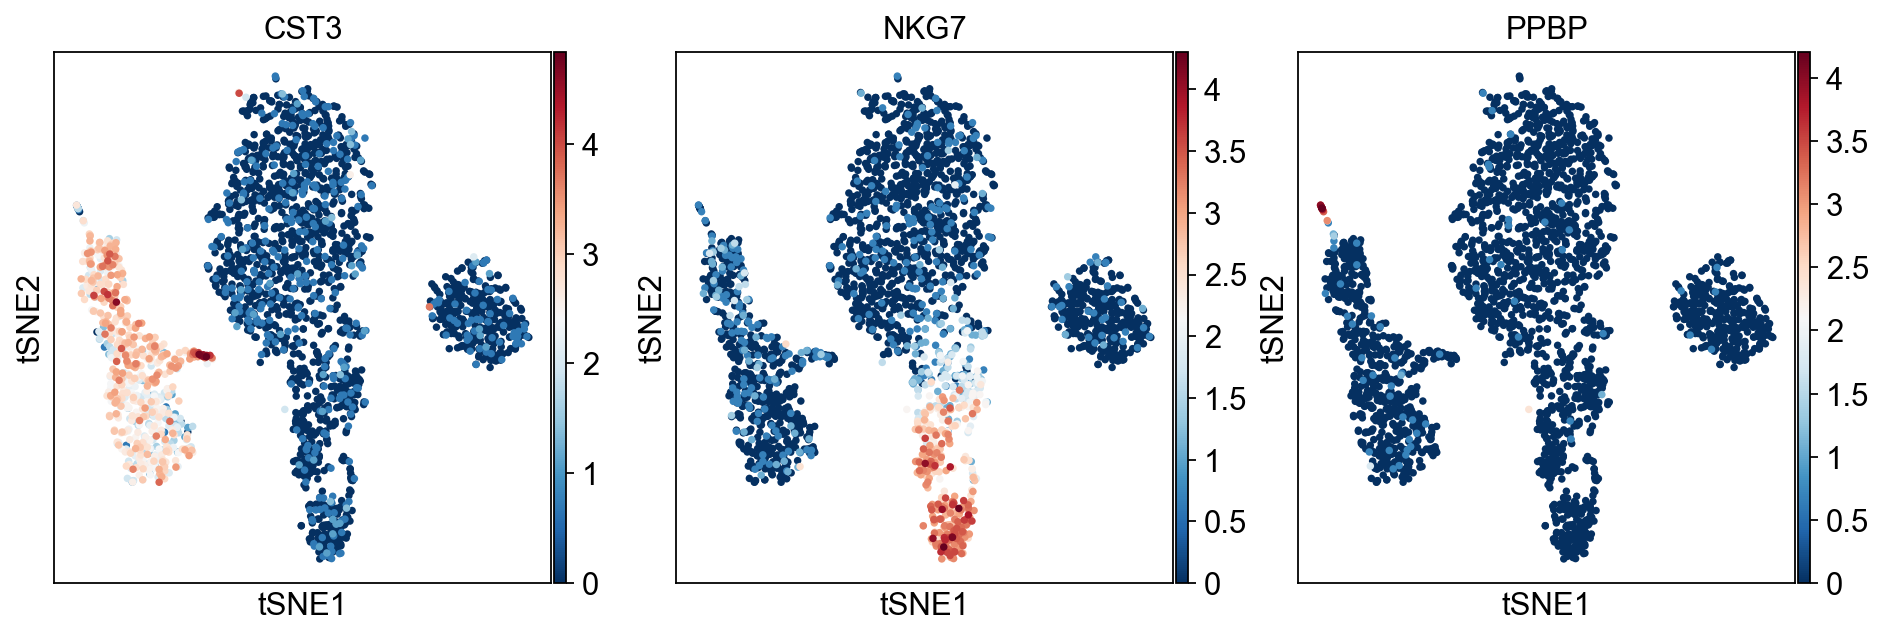

In [23]:
sc.pl.tsne(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of AnnData (a "frozen" state of the object at a point in the pipeline where we deemed the data "raw"), the previous plots showed the raw gene expression.

## Computing the neighborhood graph

In [24]:
adata = sc.read(results_file)

In [25]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:03.71) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


Get a quick visualization of the graph using UMAP. For larger data, the speedup over tSNE will be dramatic.

In [26]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:06.09) --> added
    'X_umap', UMAP coordinates (adata.obsm)


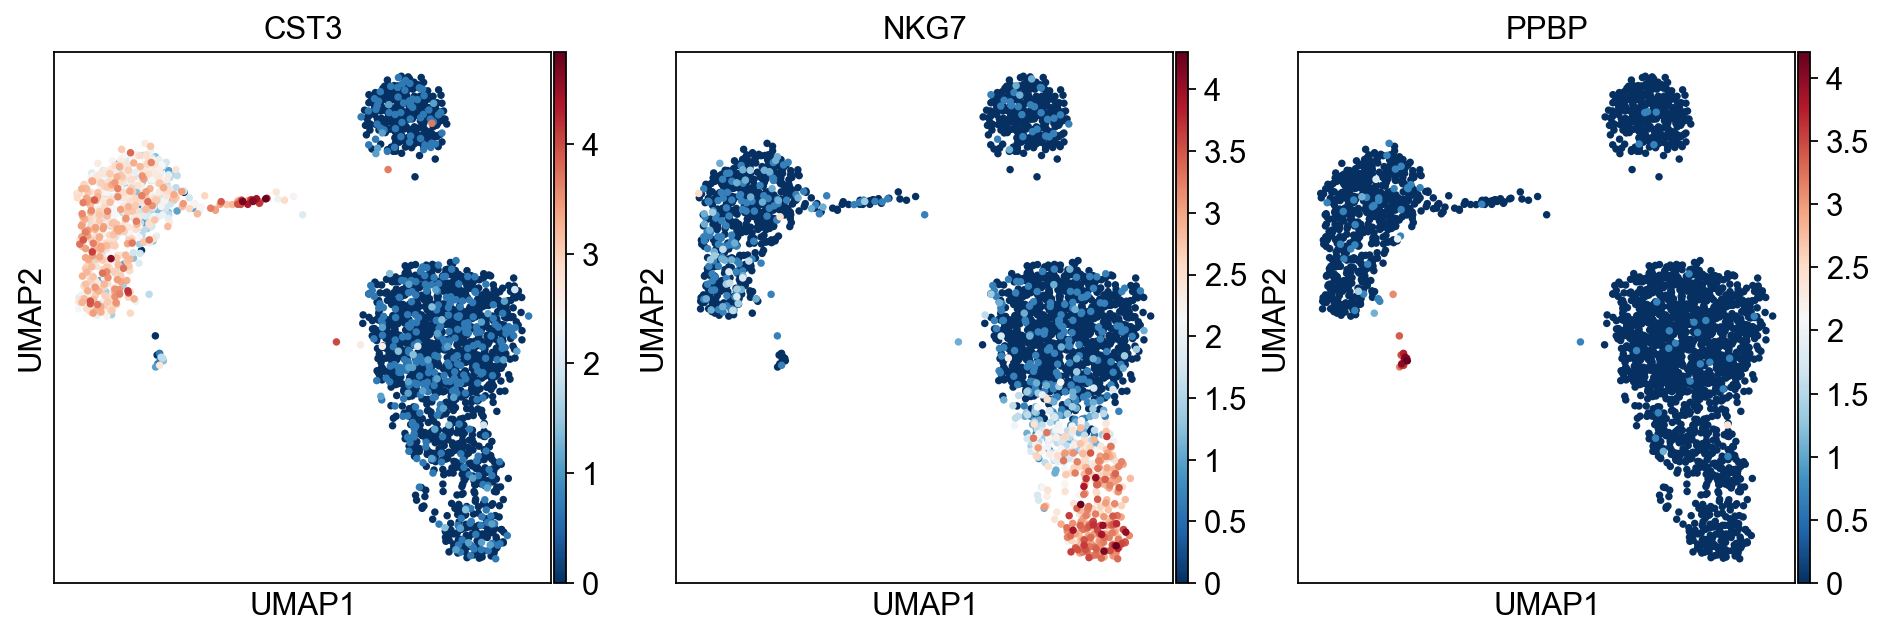

In [27]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

Btw: You can also plot the normalized and corrected gene expression by explicitly stating that you don't want to use `.raw`.

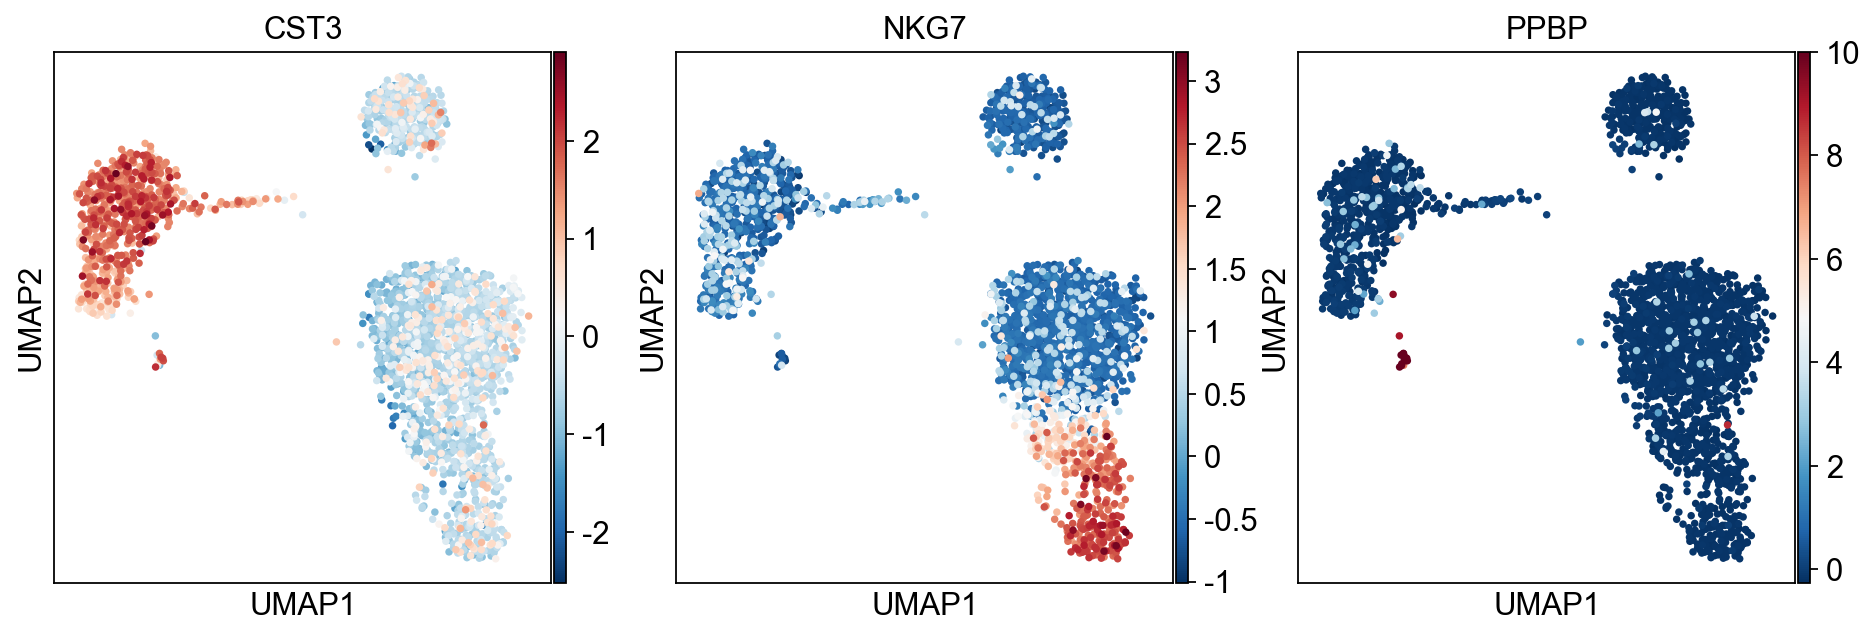

In [28]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the graph

As Seurat and many others, we use the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.04).

In order to run Louvain clustering, we first need to compute the neighborhood graph of cells - we already did this in the previous section.

In [29]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.29) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

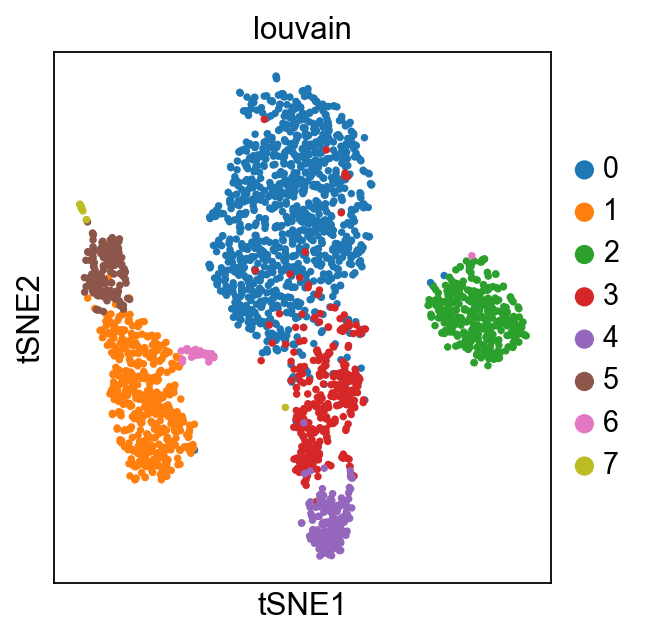

In [30]:
sc.pl.tsne(adata, color='louvain')

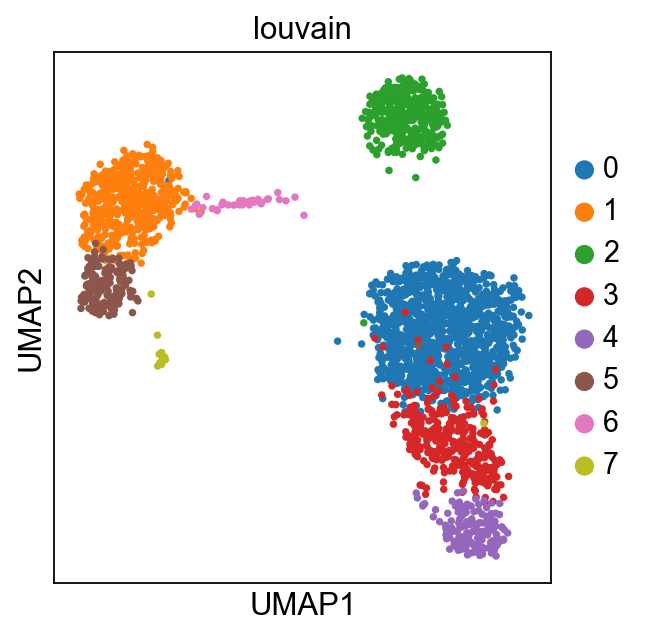

In [31]:
sc.pl.umap(adata, color='louvain')

In [32]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes with a t test, which agrees quite well with Seurat.

For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before.

ranking genes
    finished (0:00:00.79) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain.pdf


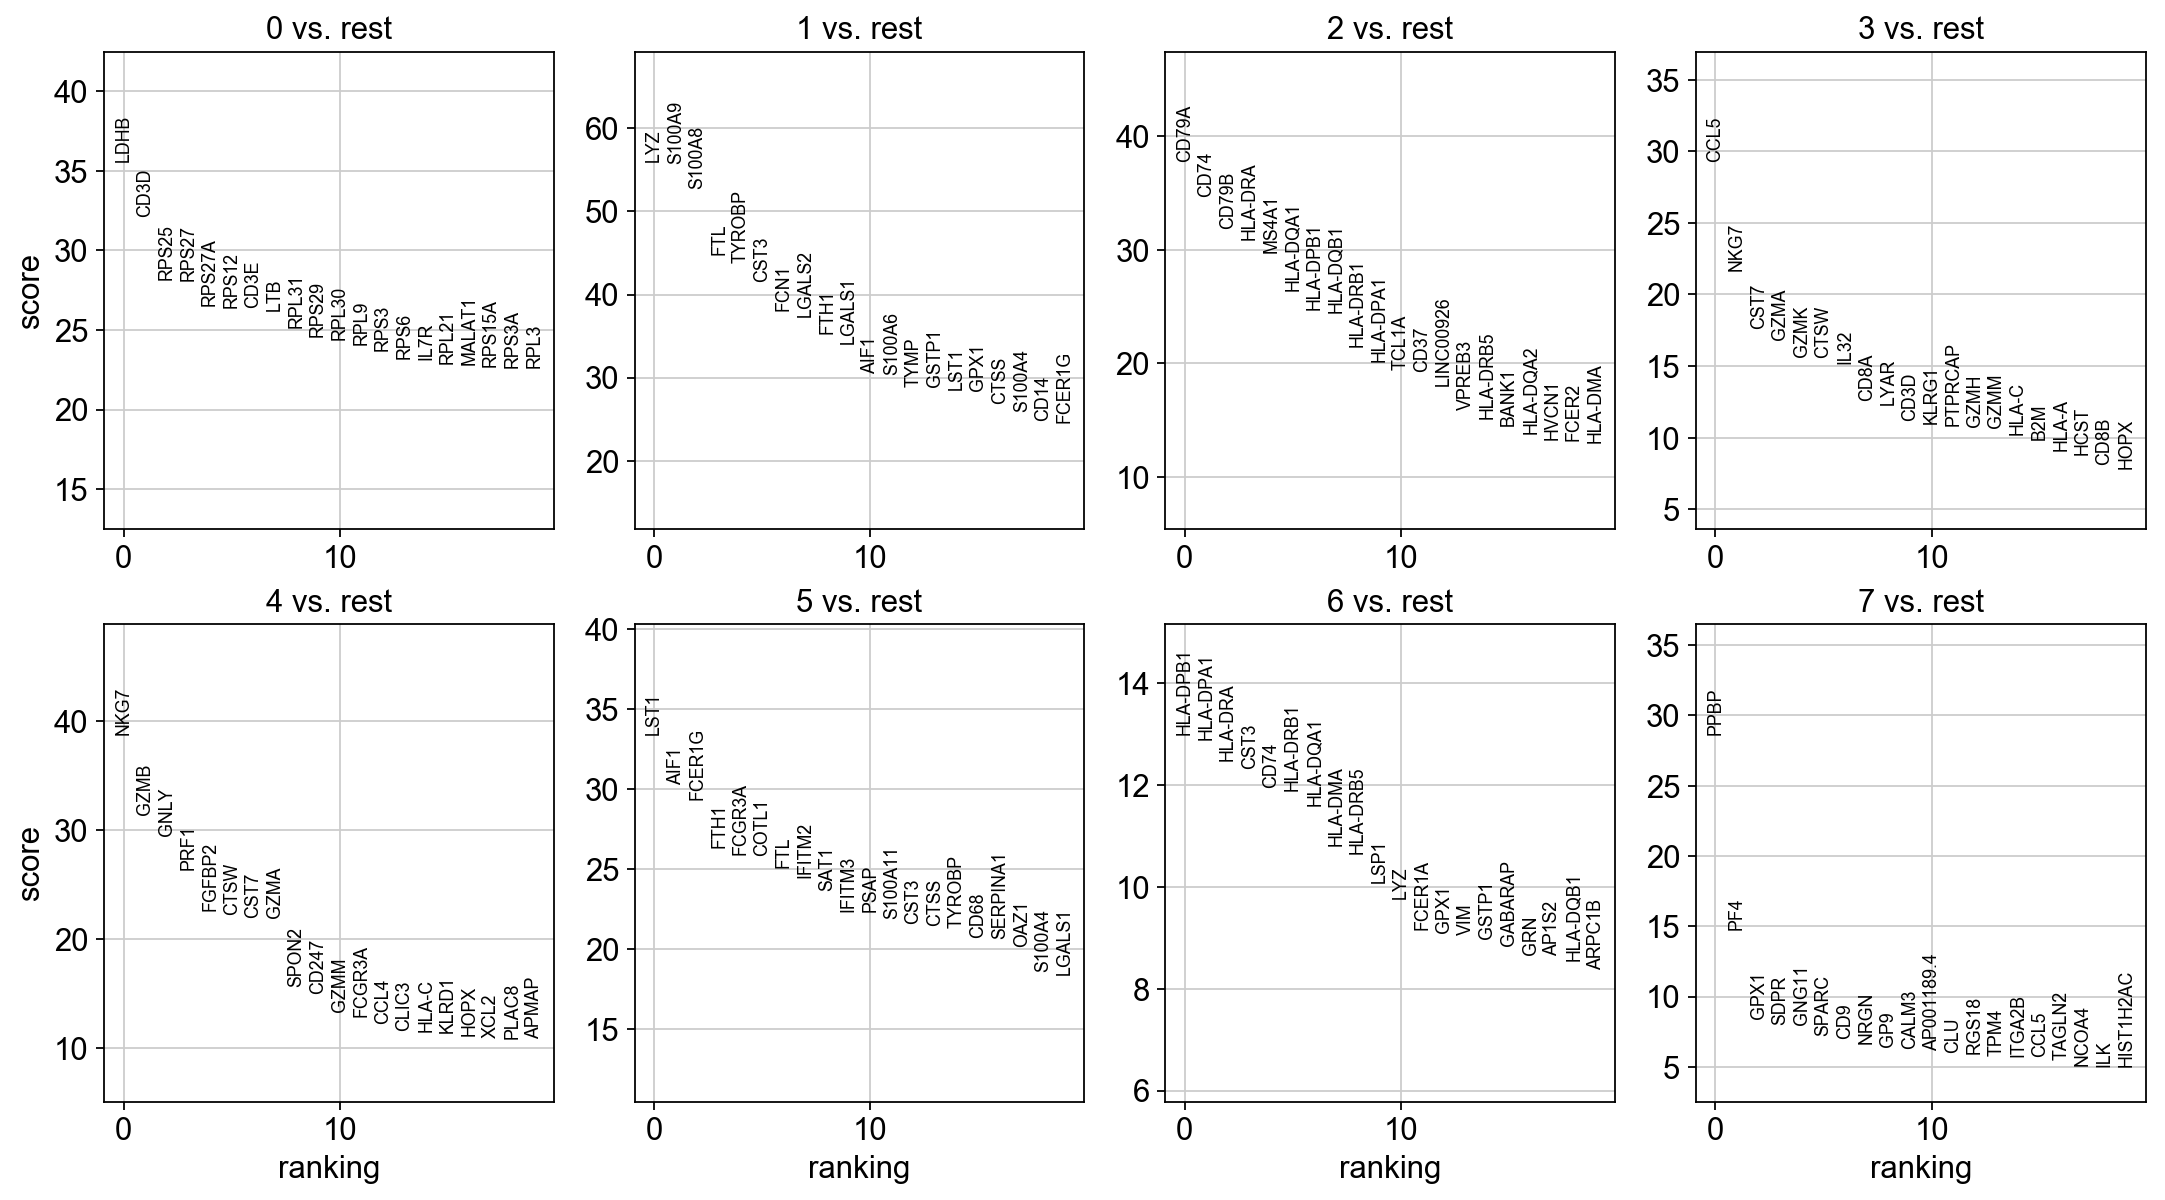

In [33]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20, save='.pdf')
adata.write(results_file)

In [34]:
sc.settings.verbosity = 2  # reduce the verbosity to no longer see hints

Here, we rank genes using logistic regression. For instance, this has been suggested by [Natranos *et al.* (2018)](https://doi.org/10.1101/258566). We think that this works very well. Here, it recovers known marker genes at higer rankings than using a t-test or Wilcoxon rank sum test.

ranking genes
    finished (0:00:04.12)


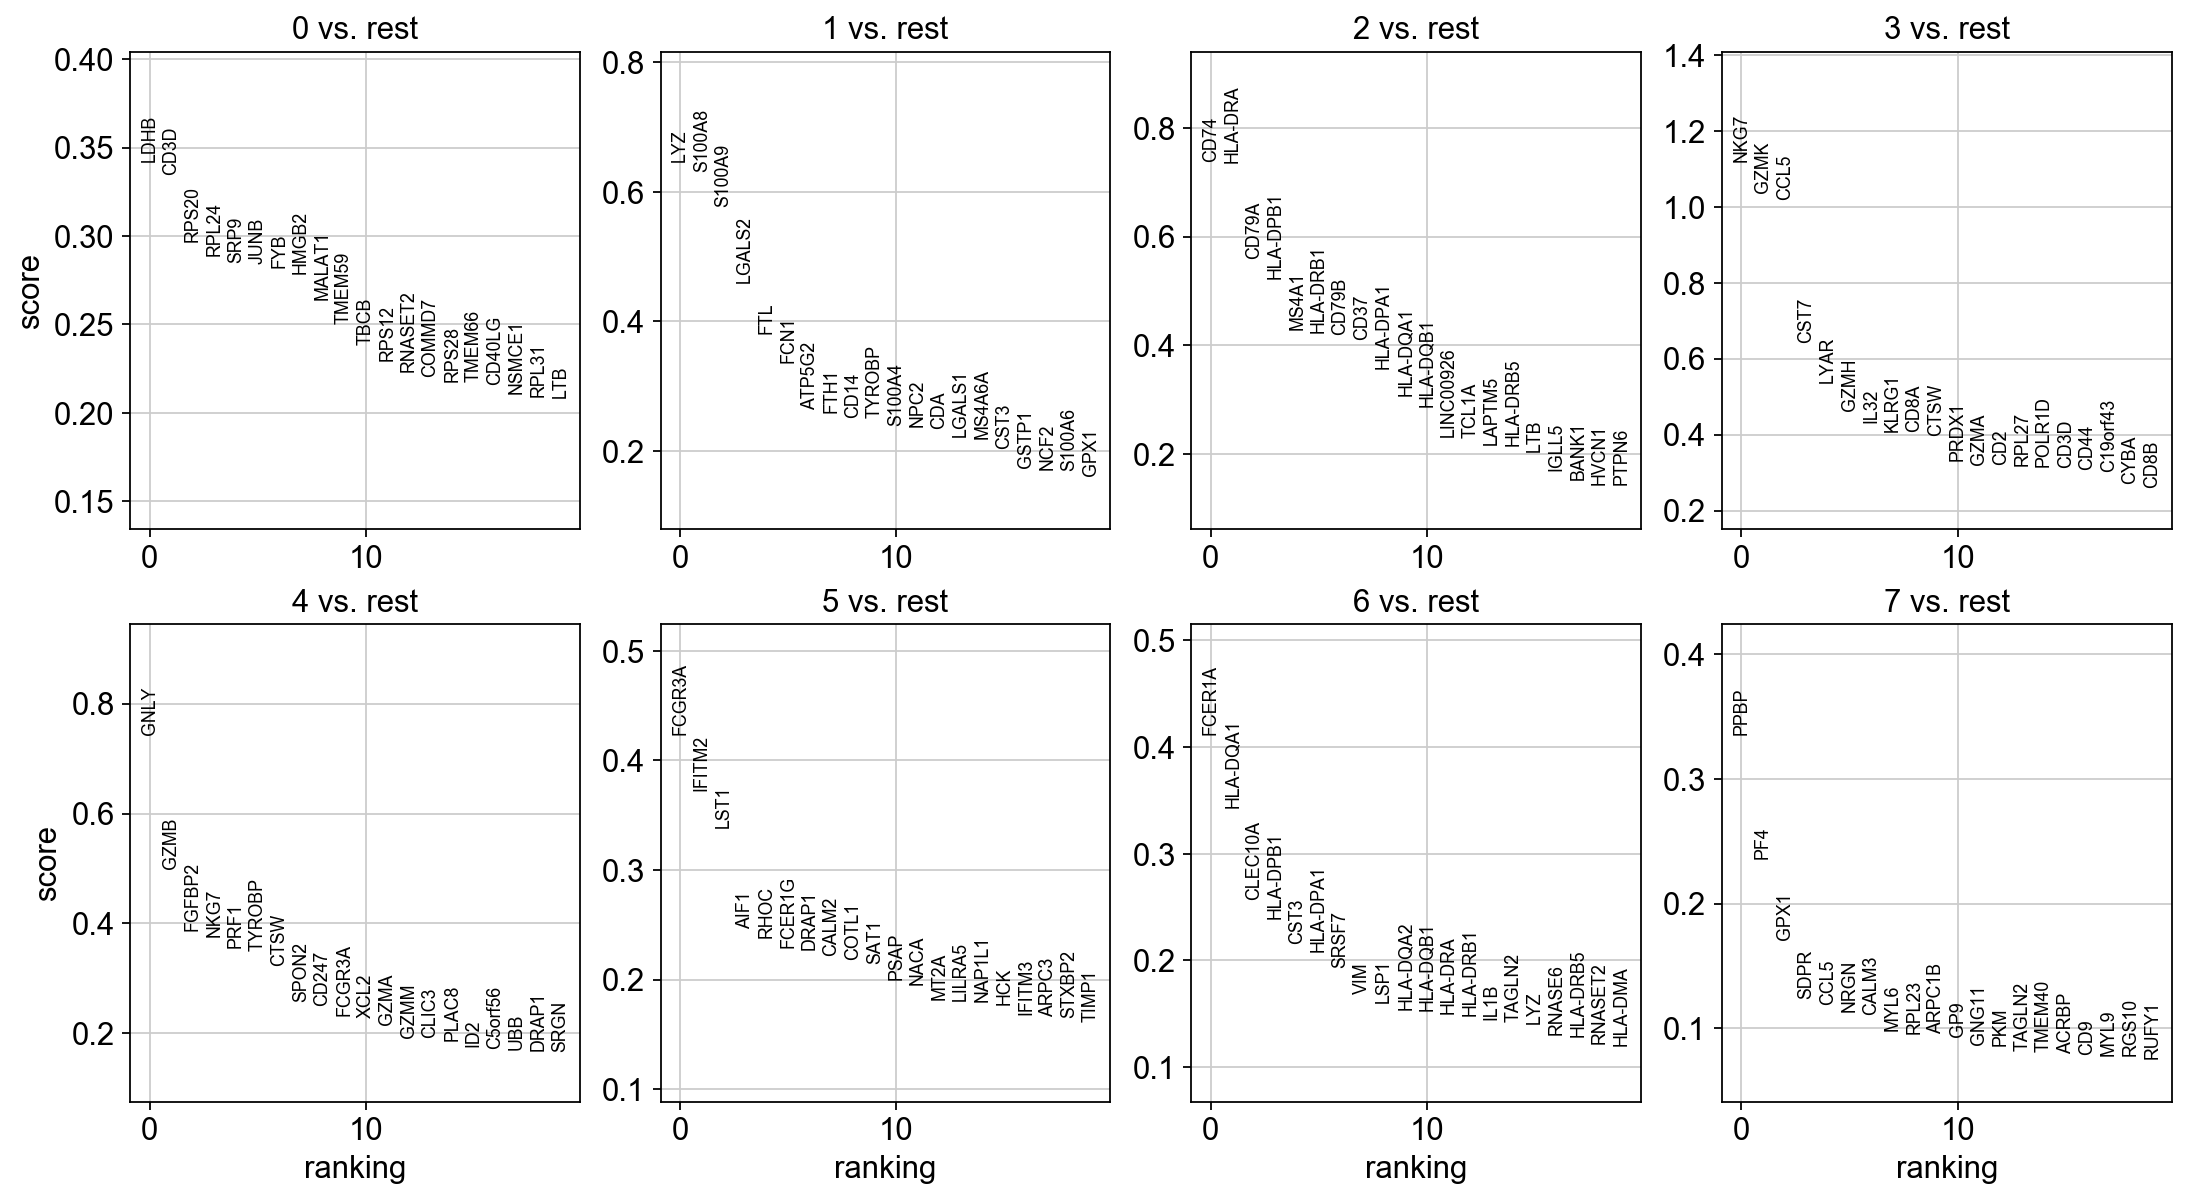

In [35]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=20)

With the exception of IL7R, which is only found by the t-test at rank 14, all marker genes are recovered.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 |	CD8A |	CD8 T cells
4 |	GNLY, NKG7 | 	NK cells
5 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 |	FCER1A, CST3 |	Dendritic Cells
7 |	PPBP |	Megakaryocytes

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [36]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,LDHB,LYZ,CD74,NKG7,GNLY,FCGR3A,FCER1A,PPBP
1,CD3D,S100A8,HLA-DRA,GZMK,GZMB,IFITM2,HLA-DQA1,PF4
2,RPS20,S100A9,CD79A,CCL5,FGFBP2,LST1,CLEC10A,GPX1
3,RPL24,LGALS2,HLA-DPB1,CST7,NKG7,AIF1,HLA-DPB1,SDPR
4,SRP9,FTL,MS4A1,LYAR,PRF1,RHOC,CST3,CCL5


Get a table with scores and groups.

In [37]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,5_n,5_s,6_n,6_s,7_n,7_s
0,LDHB,0.341800,LYZ,0.645806,CD74,0.737052,NKG7,1.117407,GNLY,0.743704,FCGR3A,0.423538,FCER1A,0.411672,PPBP,0.335548
1,CD3D,0.334587,S100A8,0.631597,HLA-DRA,0.736403,GZMK,1.037850,GZMB,0.498910,IFITM2,0.371949,HLA-DQA1,0.343262,PF4,0.235685
2,RPS20,0.296700,S100A9,0.576457,CD79A,0.559587,CCL5,1.019688,FGFBP2,0.387769,LST1,0.338959,CLEC10A,0.257300,GPX1,0.171085
3,RPL24,0.288940,LGALS2,0.459115,HLA-DPB1,0.523043,CST7,0.642467,NKG7,0.376635,AIF1,0.246510,HLA-DPB1,0.239372,SDPR,0.123983
4,SRP9,0.285027,FTL,0.380529,MS4A1,0.428465,LYAR,0.537460,PRF1,0.356204,RHOC,0.238368,CST3,0.215620,CCL5,0.119158


Compare to a single cluster. 

ranking genes
    finished (0:00:00.07)


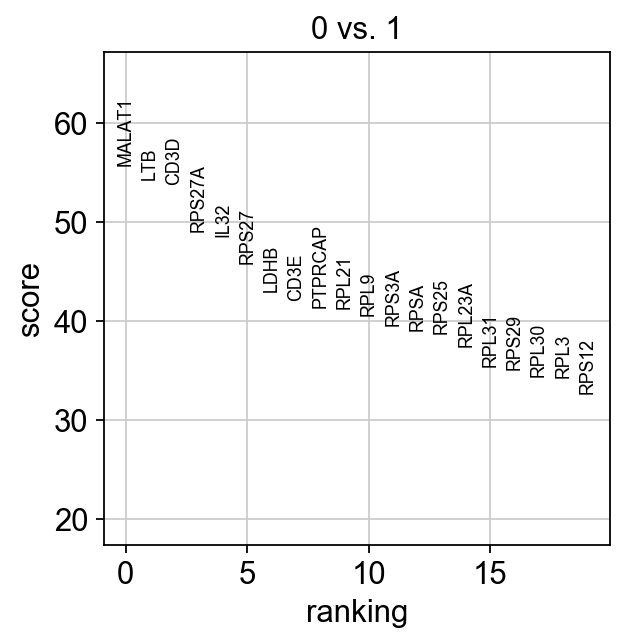

In [38]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

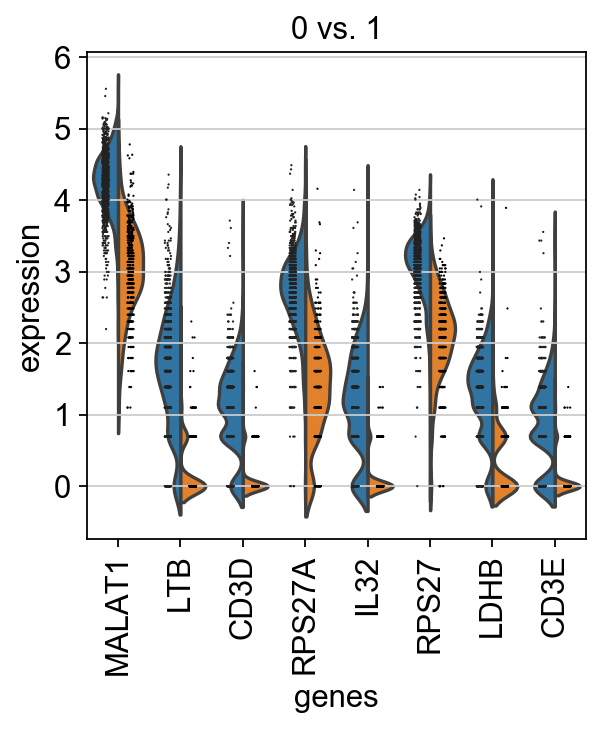

In [39]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reread the examples that were computed by comparing to the rest of the groups.

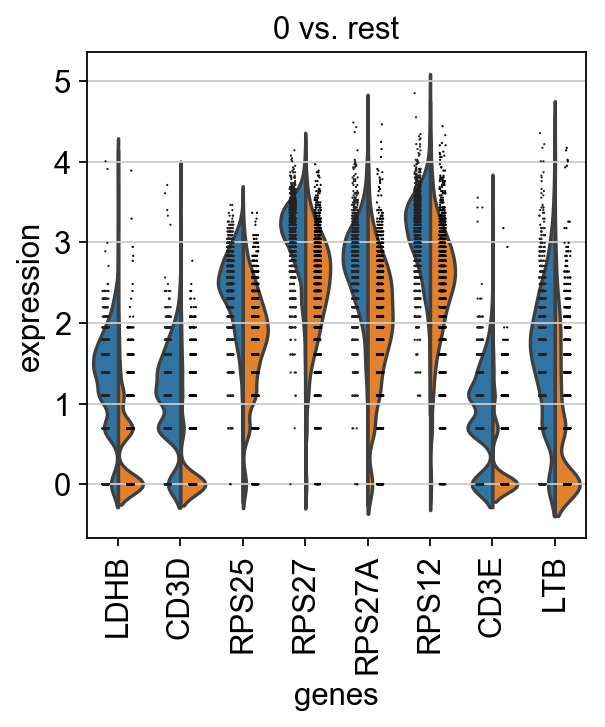

In [40]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

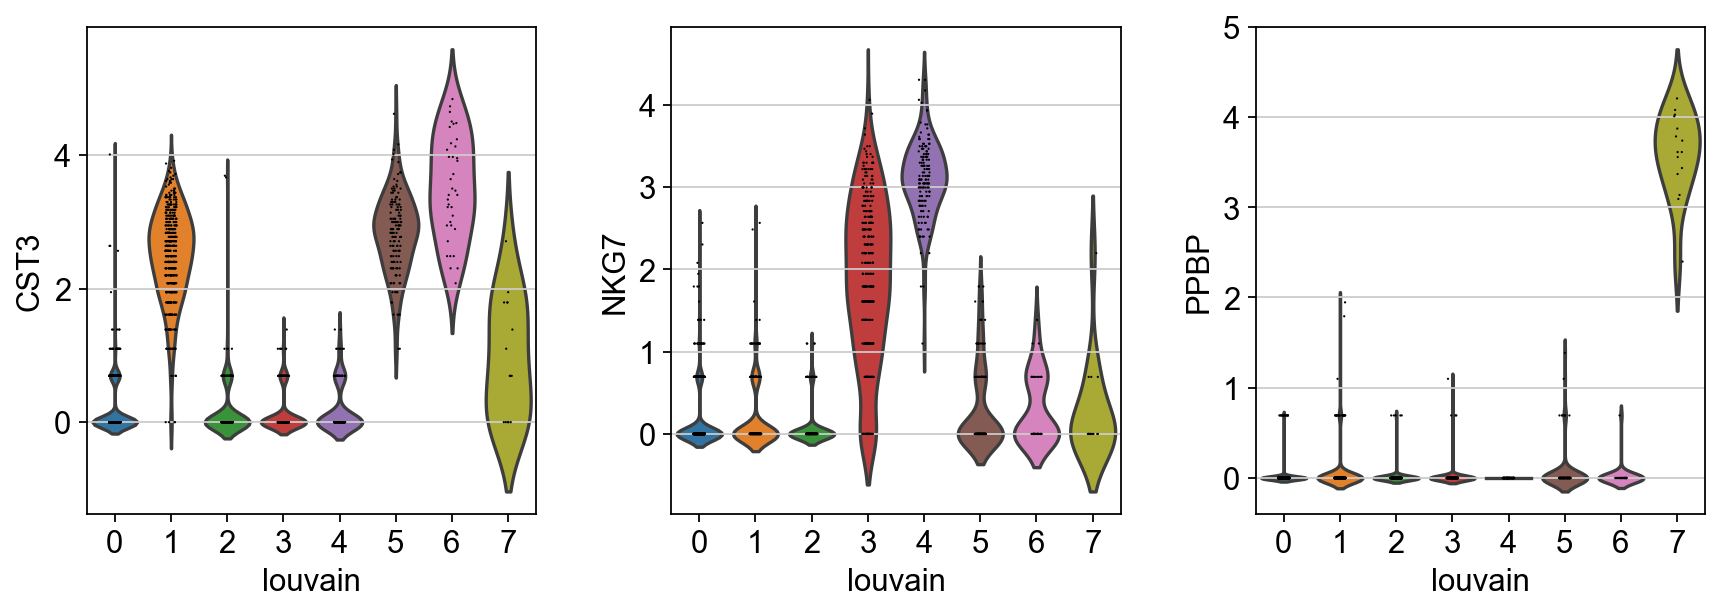

In [41]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

Actually mark the cell types.

In [42]:
adata.obs['louvain'].cat.categories = [
    'CD4 T cells', 'CD14+ Monocytes',
    'B cells', 'CD8 T cells', 
    'NK cells', 'FCGR3A+ Monocytes',
    'Dendritic cells', 'Megakaryocytes']

saving figure to file ./figures/tsne.pdf


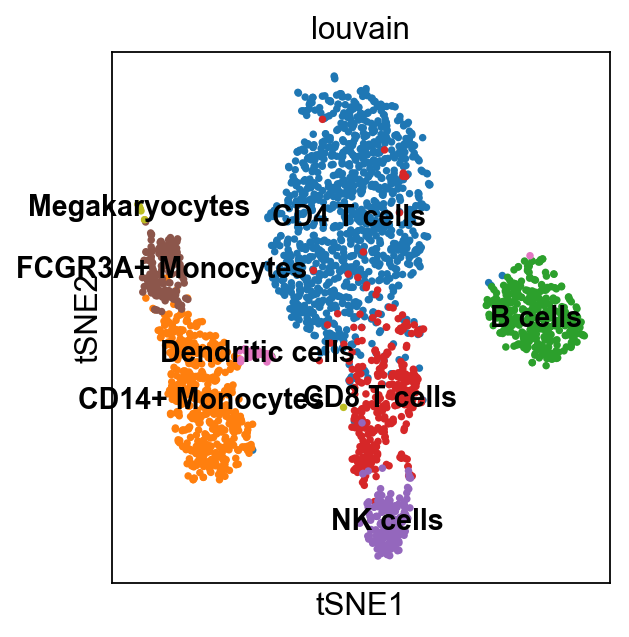

In [43]:
sc.pl.tsne(adata, color='louvain', legend_loc='on data', save='.pdf')

saving figure to file ./figures/violin.pdf


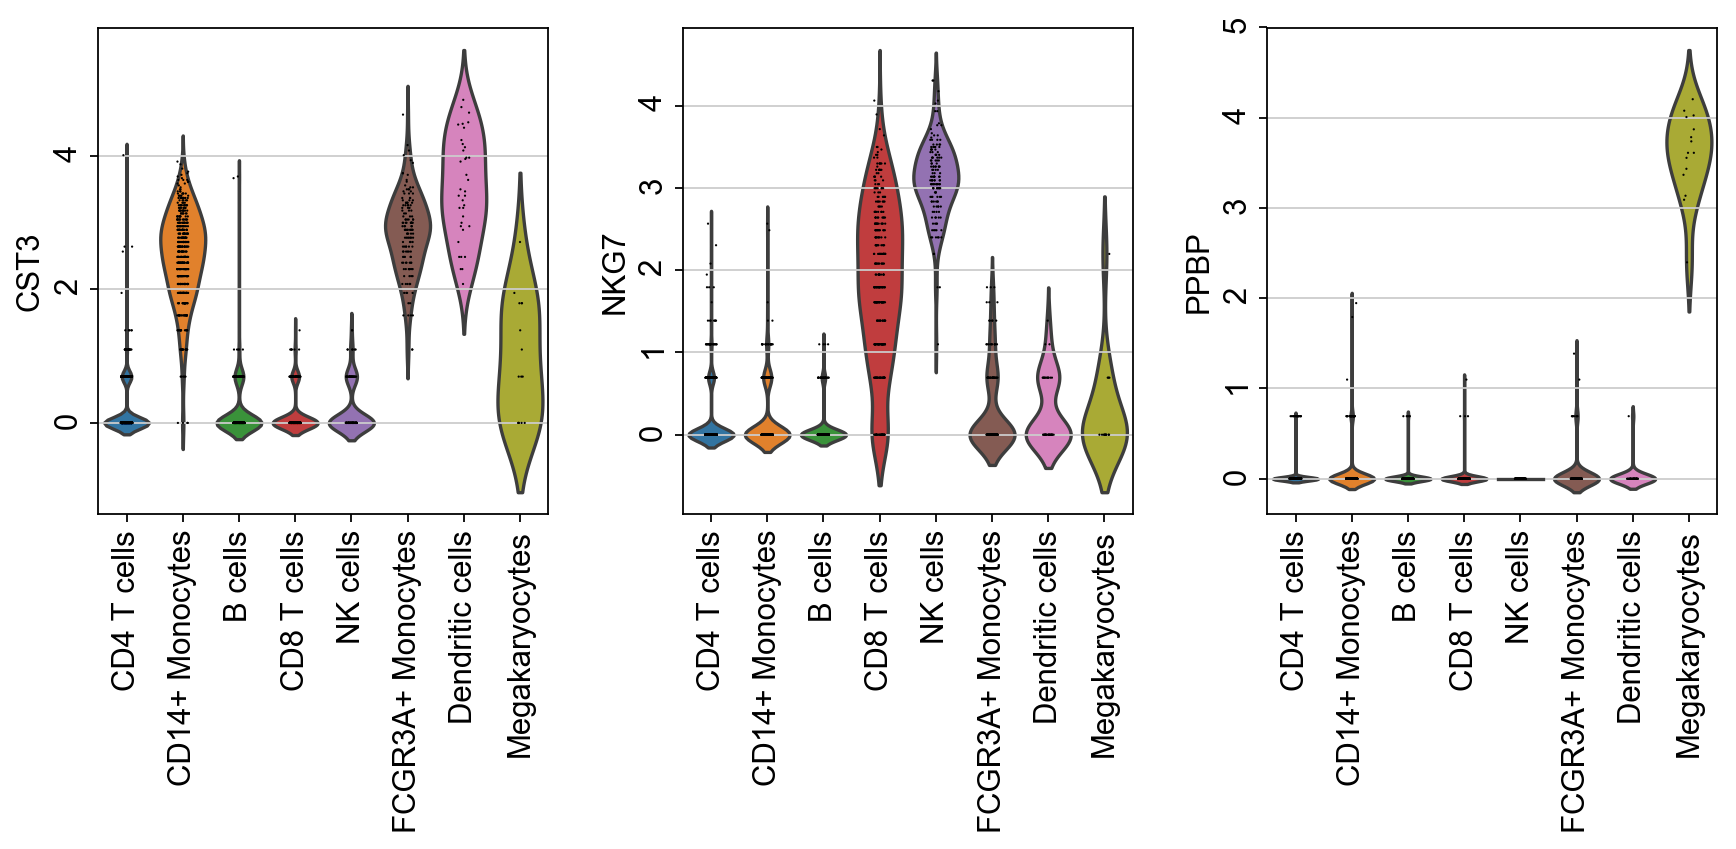

In [44]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain', rotation=90, save='.pdf')

Our AnnData now accumlated the following annotations.

In [45]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [46]:
adata.write(results_file)

If you want to export to "csv", you have the following options:

In [47]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )